Error parsing GPU log at line 58833: list index out of range


C:\Users\Sjard\AppData\Local\Temp\ipykernel_861128\2733521333.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.0000e-02 1.0500e+00 1.9600e+00 2.9600e+00 3.9700e+00 4.9700e+00
 5.9700e+00 7.0000e+00 8.0100e+00 9.0400e+00 1.0040e+01 1.1050e+01
 1.1950e+01 1.2960e+01 1.3970e+01 1.4970e+01 1.5990e+01 1.7000e+01
 1.8010e+01 1.9030e+01 2.0040e+01 2.1050e+01 2.1960e+01 2.2970e+01
 2.3990e+01 2.5000e+01 2.6010e+01 2.7030e+01 2.8040e+01 2.9050e+01
 2.9960e+01 3.0980e+01 3.1990e+01 3.3000e+01 3.4010e+01 3.5020e+01
 3.6020e+01 3.7040e+01 3.7960e+01 3.8970e+01 3.9970e+01 4.0990e+01
 4.1990e+01 4.2990e+01 4.4000e+01 4.5000e+01 4.6010e+01 4.7020e+01
 4.8030e+01 4.9030e+01 5.0040e+01 5.0950e+01 5.1970e+01 5.2970e+01
 5.3980e+01 5.4980e+01 5.5990e+01 5.6990e+01 5.7990e+01 5.9000e+01
 6.0000e+01 6.1000e+01 6.2000e+01 6.3010e+01 6.4010e+01 6.5010e+01
 6.6020e+01 6.7010e+01 6.8010e+01 6.9010e+01 7.0020e+01 7.1020e+0

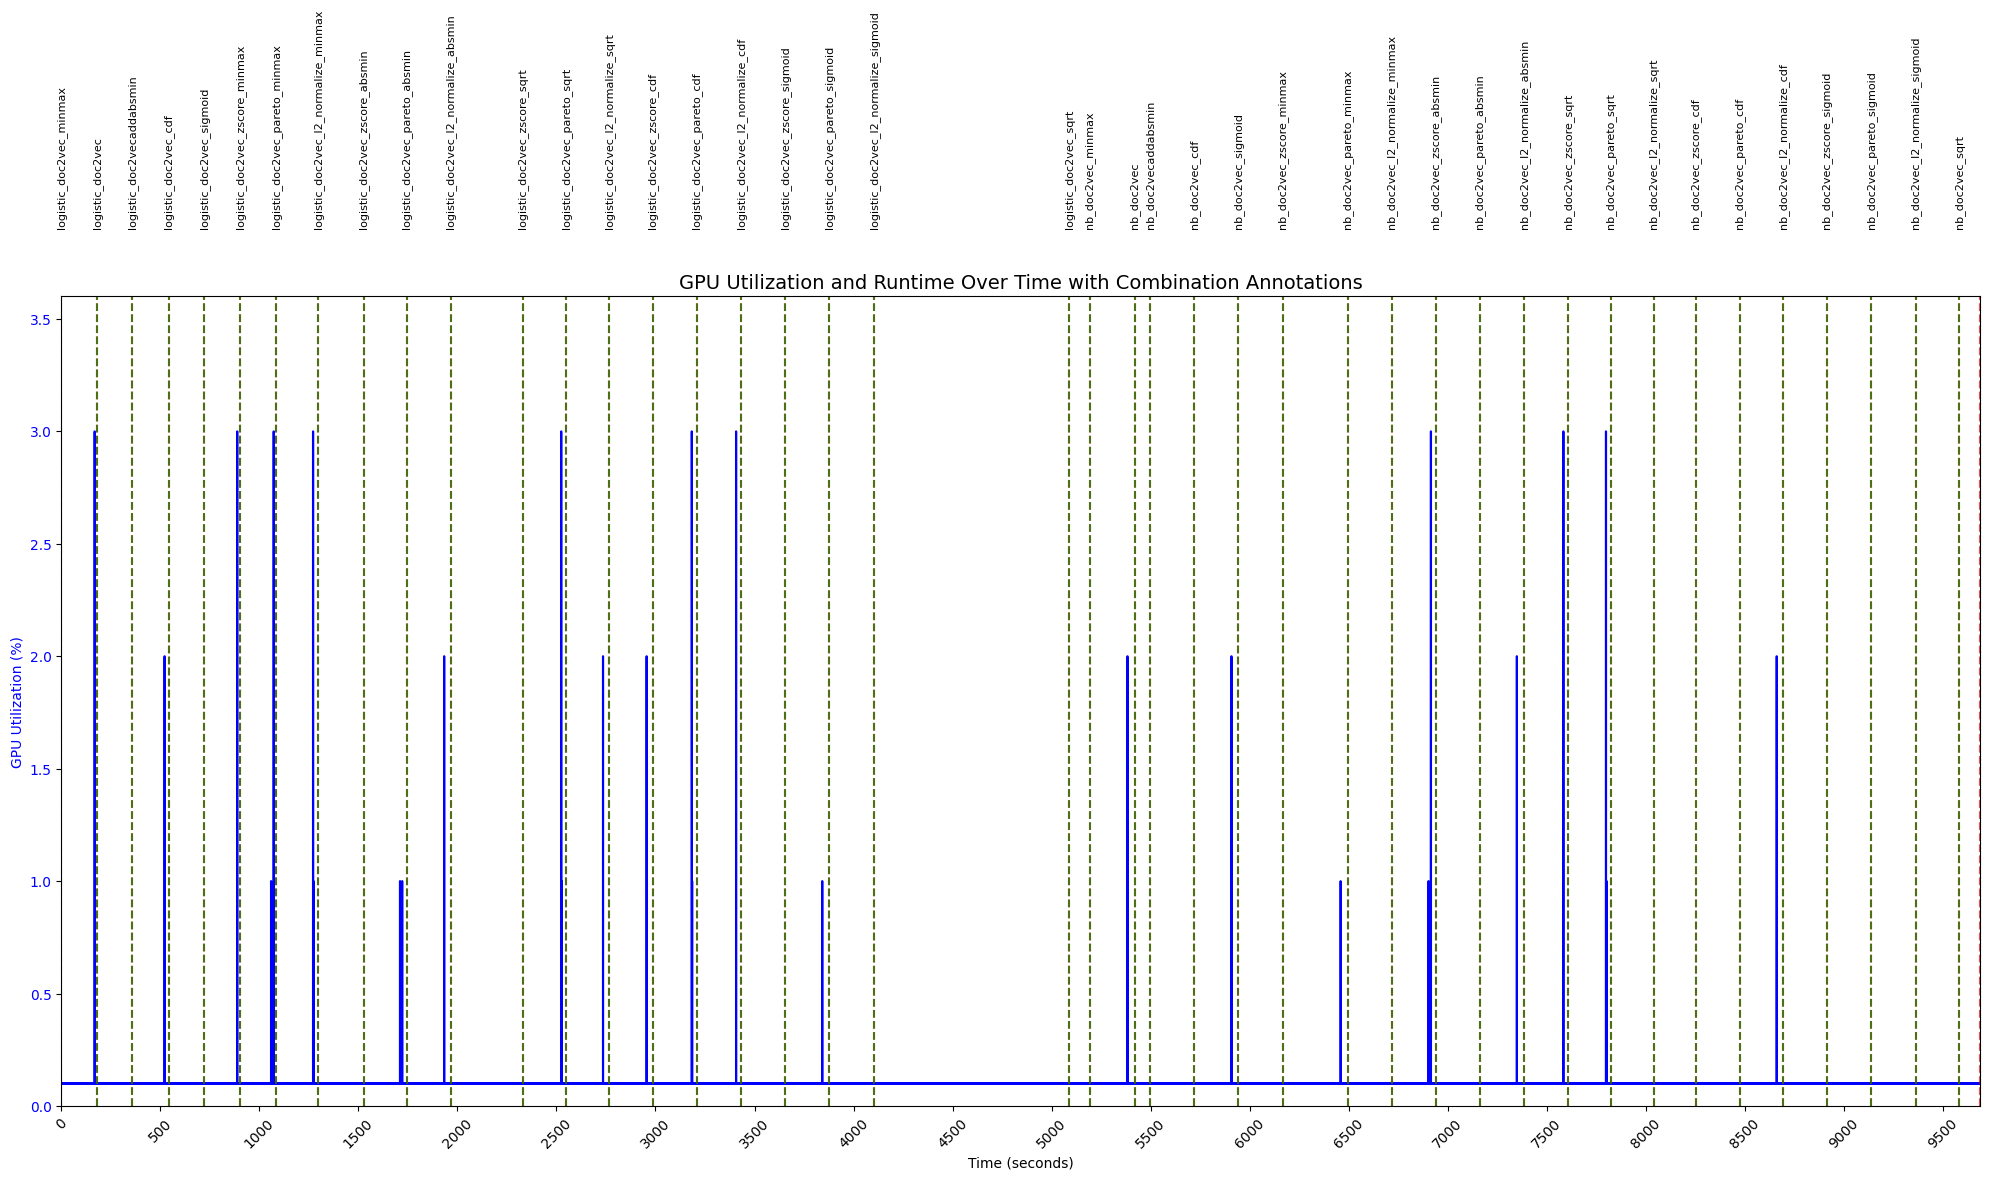

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Calculate GPU utilization seconds based on cumulative runtime
gpu_df['Cumulative_Start_Seconds'] = 0
gpu_df['Cumulative_End_Seconds'] = 0

current_time = 0
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['Start_Time'][mask] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['End_Time'][mask] - row['Start_Time']).dt.total_seconds()
    current_time = row['Cumulative_End_Seconds']

# Create the Graph
fig, ax1 = plt.subplots(figsize=(20, 12))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Cumulative_Start_Seconds'], row['Cumulative_End_Seconds']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

# Add a small offset to make low values visible
gpu_utils = [max(0.1, u) for u in gpu_utils]

ax1.plot(gpu_times, gpu_utils, color='b')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GPU Utilization (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Adjust y-axis limits
max_util = max(gpu_utils)
ax1.set_ylim(0, max_util * 1.2)

# Adjust x-axis limits
ax1.set_xlim(0, max(gpu_times))

# Annotate the plot with combinations and runtime
for i, row in comb_df.iterrows():
    ax1.axvline(x=row['Cumulative_Start_Seconds'], color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=row['Cumulative_End_Seconds'], color='r', linestyle='--', alpha=0.7)
    ax1.text(row['Cumulative_Start_Seconds'], max_util * 1.2 +  max_util * 0.1, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8, ha='center')

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

plt.xticks(rotation=45)

# Add title and legend
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [8]:
import re
from datetime import datetime, timedelta
import os

def parse_time(time_str):
    return datetime.strptime(time_str, "%H:%M:%S,%f")

def parse_results(results_content):
    pattern = re.compile(r"Running classifier: (\w+) with feature extractor: (\w+).*?Start Time:\s+(\d+:\d+:\d+,\d+).*?End Time:\s+(\d+:\d+:\d+,\d+)", re.DOTALL)
    return [(f"{m.group(1)}_{m.group(2)}", parse_time(m.group(3)), parse_time(m.group(4))) for m in pattern.finditer(results_content)]

def parse_metrics(metrics_content):
    pattern = re.compile(r"Time start:\s+(\d+:\d+:\d+,\d+).*?utilization\.gpu \[%\]\s*(\d+) %", re.DOTALL)
    return [(parse_time(m.group(1)), int(m.group(2))) for m in pattern.finditer(metrics_content)]

def calculate_gpu_utilization(start_time, end_time, metrics):
    relevant_metrics = [gpu for time, gpu in metrics if start_time <= time <= end_time]
    return sum(relevant_metrics) / len(relevant_metrics) if relevant_metrics else 0

def main():
    results_file = 'results.log'
    metrics_file = 'system_metrics.log'
    
    print(f"Current working directory: {os.getcwd()}")
    print(f"Attempting to read results from: {results_file}")
    print(f"Attempting to read metrics from: {metrics_file}")
    
    if not os.path.exists(results_file):
        print(f"Error: The file '{results_file}' does not exist.")
        print("Files in the directory:")
        for file in os.listdir():
            print(f"  {file}")
        return []
    
    try:
        with open(results_file, 'r') as f:
            results_content = f.read()
        
        with open(metrics_file, 'r') as f:
            metrics_content = f.read()
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return []
    
    results = parse_results(results_content)
    metrics = parse_metrics(metrics_content)
    
    output = []
    for combination, start_time, end_time in results:
        runtime = (end_time - start_time).total_seconds()
        gpu_utilization = calculate_gpu_utilization(start_time, end_time, metrics)
        output.append({
            'combination': combination,
            'runtime': runtime,
            'gpu_utilization': gpu_utilization
        })
    
    return output

# Run the main function
results = main()

if results:
    # Define the output file name
    output_file = 'parsed_results.txt'
    
    # Append results to the file
    with open(output_file, 'a') as f:
        for result in results:
            f.write(f"Combination: {result['combination']}\n")
            f.write(f"Runtime: {result['runtime']} seconds\n")
            f.write(f"GPU Utilization: {result['gpu_utilization']:.2f}%\n")
            f.write("\n")
    
    print(f"Results have been appended to {output_file}")
    
    # Print results to console as well
    for result in results:
        print(f"Combination: {result['combination']}")
        print(f"Runtime: {result['runtime']} seconds")
        print(f"GPU Utilization: {result['gpu_utilization']:.2f}%")
        print()
else:
    print("No results were processed. Please check the file paths and try again.")

# Additional debugging information
print("\nList of files in the current directory:")
for item in os.listdir():
    print(item)

Current working directory: c:\Users\Sjard\OneDrive - Universiteit Utrecht\Thesis\ASReview\Simulation_study_PTSD\Makita\doc2vec_all
Attempting to read results from: results.log
Attempting to read metrics from: system_metrics.log
Results have been appended to parsed_results.txt
Combination: logistic_doc2vec_minmax
Runtime: 182.87 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec
Runtime: 174.43 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vecaddabsmin
Runtime: 186.56 seconds
GPU Utilization: 0.01%

Combination: logistic_doc2vec_cdf
Runtime: 179.09 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_sigmoid
Runtime: 180.93 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_zscore_minmax
Runtime: 182.38 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_pareto_minmax
Runtime: 210.97 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_l2_normalize_minmax
Runtime: 228.8 seconds
GPU Utilization: 0.00%

Combination: logistic_do

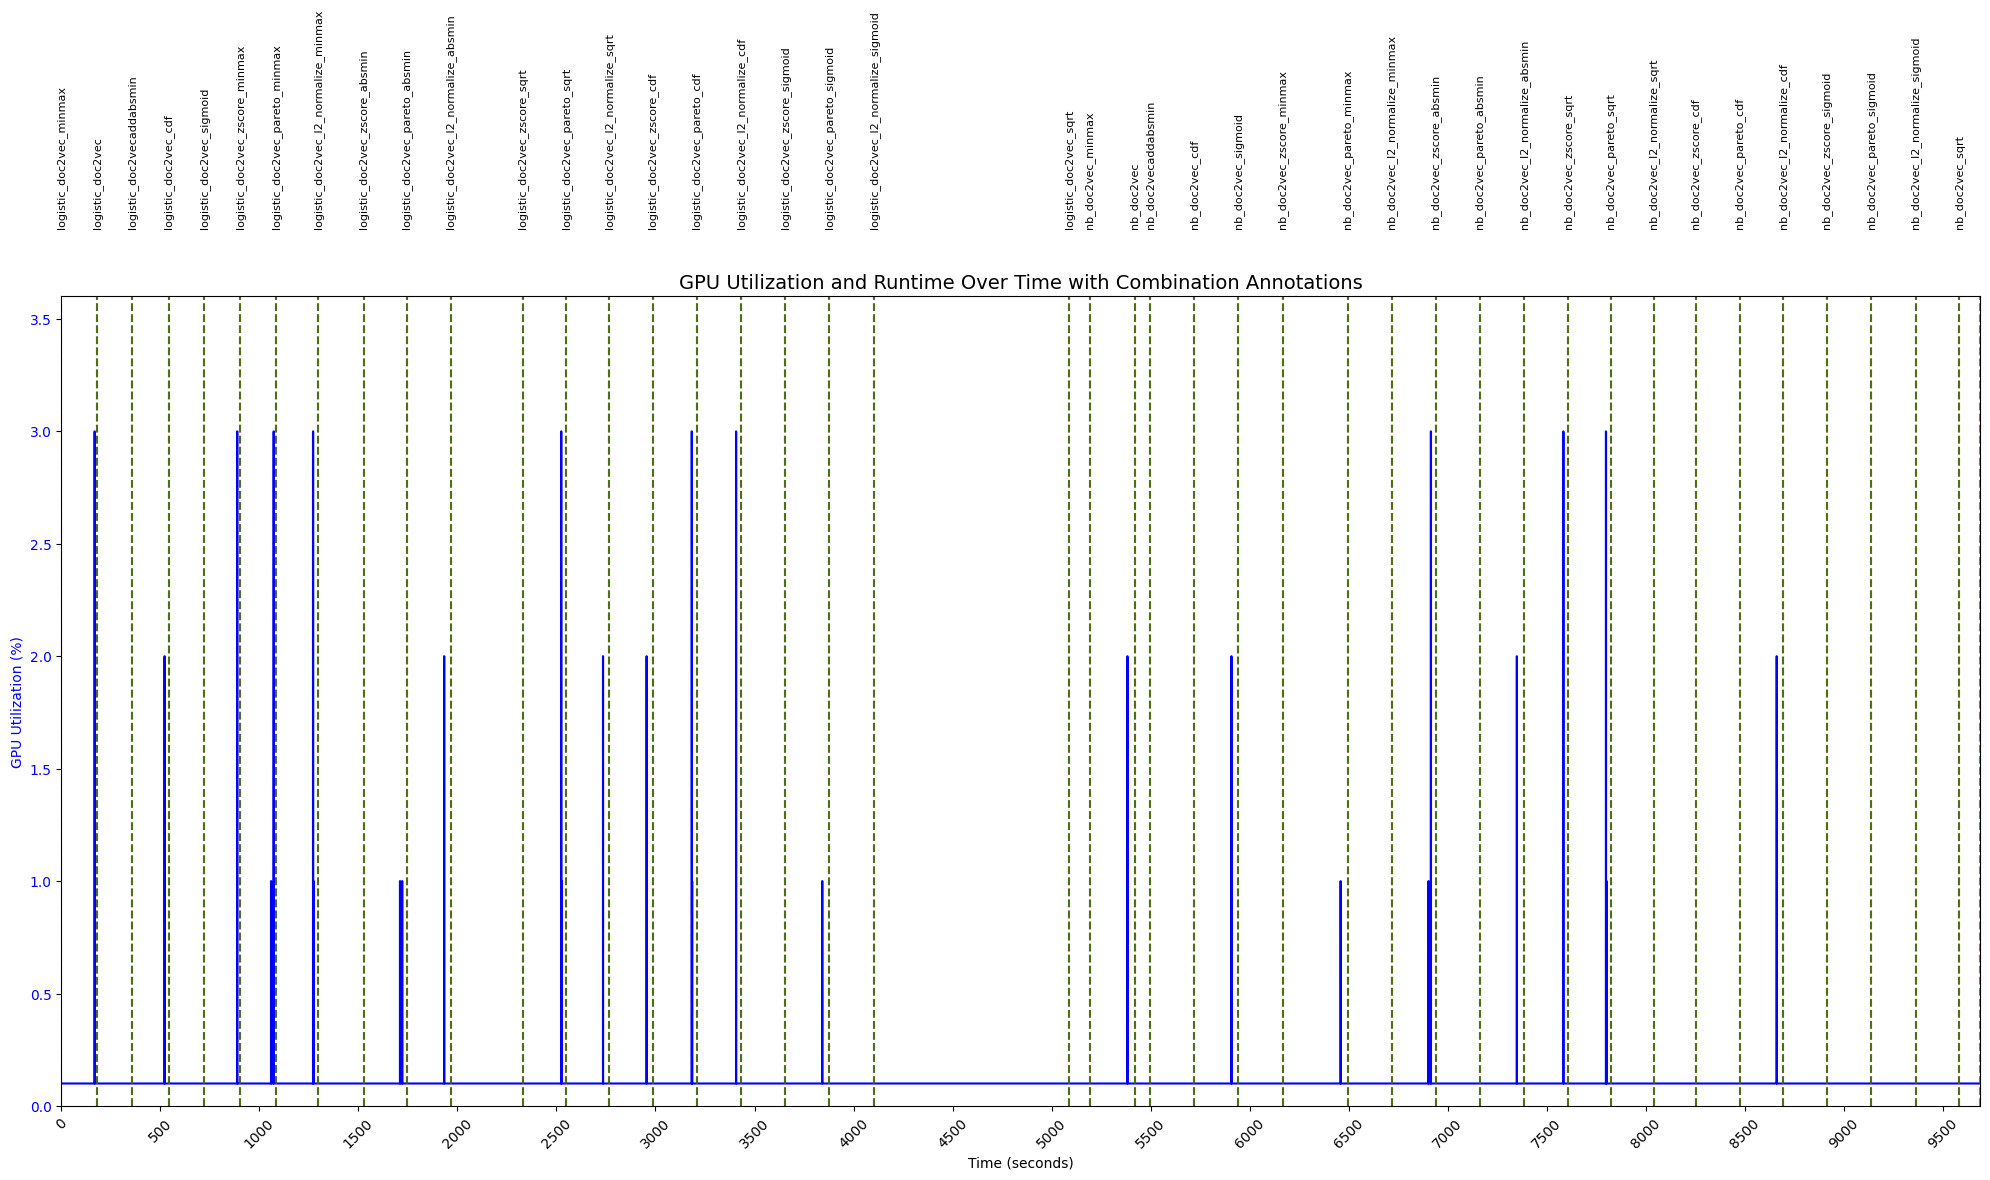

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
                i += 1
                continue
            elif line.startswith('utilization.gpu [%]'):
                if i + 2 < len(lines):  # Check if we have enough lines
                    gpu_util = int(lines[i + 1].strip().replace('%', ''))
                    end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                    if end_time < start_time:
                        end_time += pd.Timedelta(days=1)
                    gpu_data.append((start_time, end_time, gpu_util))
                    i += 2  # Skip 'Time end' line
                else:
                    i += 1
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Calculate GPU utilization seconds based on cumulative runtime
gpu_df['Cumulative_Start_Seconds'] = np.nan
gpu_df['Cumulative_End_Seconds'] = np.nan

current_time = 0
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['Start_Time'][mask] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['End_Time'][mask] - row['Start_Time']).dt.total_seconds()
    current_time = row['Cumulative_End_Seconds']

# Drop rows with NaN values
gpu_df = gpu_df.dropna()

# Create the Graph
fig, ax1 = plt.subplots(figsize=(20, 12))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Cumulative_Start_Seconds'], row['Cumulative_End_Seconds']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

# Add a small offset to make low values visible
gpu_utils = [max(0.1, u) for u in gpu_utils]

ax1.plot(gpu_times, gpu_utils, color='b')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GPU Utilization (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Adjust y-axis limits
max_util = max(gpu_utils)
ax1.set_ylim(0, max_util * 1.2)

# Adjust x-axis limits
ax1.set_xlim(0, max(gpu_times))

# Annotate the plot with combinations and runtime
for i, row in comb_df.iterrows():
    ax1.axvline(x=row['Cumulative_Start_Seconds'], color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=row['Cumulative_End_Seconds'], color='r', linestyle='--', alpha=0.7)
    ax1.text(row['Cumulative_Start_Seconds'], max_util * 1.2 +  max_util * 0.1, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8, ha='center')

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

plt.xticks(rotation=45)

# Add title and legend
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [11]:
import re
import numpy as np

def parse_data(content):
    pattern = re.compile(r'Combination: (.+)\nRuntime: (.+) seconds\nGPU Utilization: (.+)%\n')
    matches = pattern.findall(content)
    
    data = []
    for match in matches:
        combination, runtime, utilization = match
        data.append({
            'combination': combination,
            'runtime': float(runtime),
            'utilization': float(utilization)
        })
    return data

def calculate_enhanced_metrics(data):
    combinations = {}
    
    for entry in data:
        combination = entry['combination']
        utilization = entry['utilization']
        
        if combination not in combinations:
            combinations[combination] = {
                'utilizations': [],
                'runtime': entry['runtime']
            }
        
        combinations[combination]['utilizations'].append(utilization)
    
    results = []
    for combination, info in combinations.items():
        utilizations = np.array(info['utilizations'])
        runtime = info['runtime']
        
        peak_utilization = np.max(utilizations)
        non_zero_utilizations = utilizations[utilizations > 0]
        avg_non_zero_utilization = np.mean(non_zero_utilizations) if len(non_zero_utilizations) > 0 else 0
        active_percentage = len(non_zero_utilizations) / len(utilizations) * 100
        
        results.append({
            'combination': combination,
            'runtime': runtime,
            'peak_utilization': peak_utilization,
            'avg_non_zero_utilization': avg_non_zero_utilization,
            'active_percentage': active_percentage
        })
    
    return results

# Parse the data
data = parse_data('Combination: logistic_doc2vec_minmax
Runtime: 182.87 seconds
GPU Utilization: 0.01639344262295082%

Combination: logistic_doc2vec
Runtime: 174.43 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vecaddabsmin
Runtime: 186.56 seconds
GPU Utilization: 0.010752688172043012%

Combination: logistic_doc2vec_cdf
Runtime: 179.09 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vec_sigmoid
Runtime: 180.93 seconds
GPU Utilization: 0.016574585635359115%

Combination: logistic_doc2vec_zscore_minmax
Runtime: 182.38 seconds
GPU Utilization: 0.02197802197802198%

Combination: logistic_doc2vec_pareto_minmax
Runtime: 210.97 seconds
GPU Utilization: 0.018957345971563982%

Combination: logistic_doc2vec_l2_normalize_minmax
Runtime: 228.8 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vec_zscore_absmin
Runtime: 218.27 seconds
GPU Utilization: 0.009174311926605505%

Combination: logistic_doc2vec_pareto_absmin
Runtime: 220.91 seconds
GPU Utilization: 0.00904977375565611%

Combination: logistic_doc2vec_l2_normalize_absmin
Runtime: 364.97 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vec_zscore_sqrt
Runtime: 218.54 seconds
GPU Utilization: 0.018018018018018018%

Combination: logistic_doc2vec_pareto_sqrt
Runtime: 217.83 seconds
GPU Utilization: 0.009216589861751152%

Combination: logistic_doc2vec_l2_normalize_sqrt
Runtime: 219.94 seconds
GPU Utilization: 0.00909090909090909%

Combination: logistic_doc2vec_zscore_cdf
Runtime: 220.92 seconds
GPU Utilization: 0.01809954751131222%

Combination: logistic_doc2vec_pareto_cdf
Runtime: 225.08 seconds
GPU Utilization: 0.013333333333333334%

Combination: logistic_doc2vec_l2_normalize_cdf
Runtime: 221.86 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vec_zscore_sigmoid
Runtime: 223.88 seconds
GPU Utilization: 0.004464285714285714%

Combination: logistic_doc2vec_pareto_sigmoid
Runtime: 225.52 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vec_l2_normalize_sigmoid
Runtime: 984.92 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vec_sqrt
Runtime: 104.84 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_minmax
Runtime: 226.78 seconds
GPU Utilization: 0.00881057268722467%

Combination: nb_doc2vec
Runtime: 78.56 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vecaddabsmin
Runtime: 220.32 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_cdf
Runtime: 223.55 seconds
GPU Utilization: 0.008928571428571428%

Combination: nb_doc2vec_sigmoid
Runtime: 222.9 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_zscore_minmax
Runtime: 329.55 seconds
GPU Utilization: 0.0030303030303030303%

Combination: nb_doc2vec_pareto_minmax
Runtime: 220.84 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_l2_normalize_minmax
Runtime: 222.29 seconds
GPU Utilization: 0.017857142857142856%

Combination: nb_doc2vec_zscore_absmin
Runtime: 222.75 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_pareto_absmin
Runtime: 224.55 seconds
GPU Utilization: 0.008888888888888889%

Combination: nb_doc2vec_l2_normalize_absmin
Runtime: 222.69 seconds
GPU Utilization: 0.013452914798206279%

Combination: nb_doc2vec_zscore_sqrt
Runtime: 214.85 seconds
GPU Utilization: 0.023148148148148147%

Combination: nb_doc2vec_pareto_sqrt
Runtime: 217.99 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_l2_normalize_sqrt
Runtime: 212.21 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_zscore_cdf
Runtime: 220.02 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_pareto_cdf
Runtime: 220.38 seconds
GPU Utilization: 0.00909090909090909%

Combination: nb_doc2vec_l2_normalize_cdf
Runtime: 220.36 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_zscore_sigmoid
Runtime: 222.8 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_pareto_sigmoid
Runtime: 224.64 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_l2_normalize_sigmoid
Runtime: 221.52 seconds
GPU Utilization: 0.0%

Combination: nb_doc2vec_sqrt
Runtime: 104.77 seconds
GPU Utilization: 0.0%

Combination: logistic_doc2vec_minmax
Runtime: 182.87 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec
Runtime: 174.43 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vecaddabsmin
Runtime: 186.56 seconds
GPU Utilization: 0.01%

Combination: logistic_doc2vec_cdf
Runtime: 179.09 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_sigmoid
Runtime: 180.93 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_zscore_minmax
Runtime: 182.38 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_pareto_minmax
Runtime: 210.97 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_l2_normalize_minmax
Runtime: 228.8 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_zscore_absmin
Runtime: 218.27 seconds
GPU Utilization: 0.01%

Combination: logistic_doc2vec_pareto_absmin
Runtime: 220.91 seconds
GPU Utilization: 0.01%

Combination: logistic_doc2vec_l2_normalize_absmin
Runtime: 364.97 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_zscore_sqrt
Runtime: 218.54 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_pareto_sqrt
Runtime: 217.83 seconds
GPU Utilization: 0.01%

Combination: logistic_doc2vec_l2_normalize_sqrt
Runtime: 219.94 seconds
GPU Utilization: 0.01%

Combination: logistic_doc2vec_zscore_cdf
Runtime: 220.92 seconds
GPU Utilization: 0.02%

Combination: logistic_doc2vec_pareto_cdf
Runtime: 225.08 seconds
GPU Utilization: 0.01%

Combination: logistic_doc2vec_l2_normalize_cdf
Runtime: 221.86 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_zscore_sigmoid
Runtime: 223.88 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_pareto_sigmoid
Runtime: 225.52 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_l2_normalize_sigmoid
Runtime: 984.92 seconds
GPU Utilization: 0.00%

Combination: logistic_doc2vec_sqrt
Runtime: 104.84 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_minmax
Runtime: 226.78 seconds
GPU Utilization: 0.01%

Combination: nb_doc2vec
Runtime: 78.56 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vecaddabsmin
Runtime: 220.32 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_cdf
Runtime: 223.55 seconds
GPU Utilization: 0.01%

Combination: nb_doc2vec_sigmoid
Runtime: 222.9 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_zscore_minmax
Runtime: 329.55 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_pareto_minmax
Runtime: 220.84 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_l2_normalize_minmax
Runtime: 222.29 seconds
GPU Utilization: 0.02%

Combination: nb_doc2vec_zscore_absmin
Runtime: 222.75 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_pareto_absmin
Runtime: 224.55 seconds
GPU Utilization: 0.01%

Combination: nb_doc2vec_l2_normalize_absmin
Runtime: 222.69 seconds
GPU Utilization: 0.01%

Combination: nb_doc2vec_zscore_sqrt
Runtime: 214.85 seconds
GPU Utilization: 0.02%

Combination: nb_doc2vec_pareto_sqrt
Runtime: 217.99 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_l2_normalize_sqrt
Runtime: 212.21 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_zscore_cdf
Runtime: 220.02 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_pareto_cdf
Runtime: 220.38 seconds
GPU Utilization: 0.01%

Combination: nb_doc2vec_l2_normalize_cdf
Runtime: 220.36 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_zscore_sigmoid
Runtime: 222.8 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_pareto_sigmoid
Runtime: 224.64 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_l2_normalize_sigmoid
Runtime: 221.52 seconds
GPU Utilization: 0.00%

Combination: nb_doc2vec_sqrt
Runtime: 104.77 seconds
GPU Utilization: 0.00%

')

# Calculate enhanced metrics
results = calculate_enhanced_metrics(data)

# Print results
print("Enhanced GPU Utilization Metrics:")
print("----------------------------------")
for result in results:
    print(f"Combination: {result['combination']}")
    print(f"Runtime: {result['runtime']:.2f} seconds")
    print(f"Peak GPU Utilization: {result['peak_utilization']:.2f}%")
    print(f"Average Non-Zero GPU Utilization: {result['avg_non_zero_utilization']:.2f}%")
    print(f"GPU Active Time: {result['active_percentage']:.2f}%")
    print()

Enhanced GPU Utilization Metrics:
----------------------------------
